## Caffeinated 02 · Multitasking with Shot-Type Diversity Analysis

### Objective
Characterize Carlos Alcaraz's **shot portfolio** by analyzing the diversity, frequency, and effectiveness of shot types aggregated across ~250 matches using `data/shottypes.csv`.

### Caffeinated Behavior Framework

"Caffeinated" in this context refers to:
- **Sustained alertness**: Maintaining performance without decay over extended engagement
- **Cognitive endurance**: Effectiveness under tactical complexity and high-load situations

Unlike stimulant effects in humans (which are pharmacological), we use "caffeinated" 
as a behavioral metaphor for sustained high-level functioning without concentration collapse.

### Important Data Limitation

⚠️ **This dataset is aggregated across all ~250 matches, not per-match data.**

**Implications:**
- Entropy and diversity metrics are computed **once** (overall portfolio), not across matches
- We **cannot assess stability or consistency** of diversity over time or across matches
- Analyses of variability reflect **differences between shot types**, not performance variance across matches
- Claims about "tactical flexibility within matches" require per-match data

**What this analysis provides:**
- Characterization of Alcaraz's overall shot portfolio
- Effectiveness profiles across different shot families
- Risk-reward tradeoffs by shot type

**What this analysis cannot provide:**
- Match-to-match tactical flexibility
- Stability of diversity under pressure
- Comparison to other players (no baseline data)

### Definition
**Shot Portfolio Diversity** is characterized by:
- The **variety of shot types** in the repertoire
- **Effectiveness across multiple shot families** (not just one dominant shot)
- **Controlled error rates** despite tactical complexity

**Note:** This is a portfolio characterization, not a measure of match-to-match tactical switching.

### Key Questions
- How many distinct shot categories are in the repertoire?
- What is the tactical diversity index (entropy) of shot usage?
- Is Alcaraz effective across multiple shot families, not just one?
- What is the net efficiency vs risk tradeoff across shot types?
- How heterogeneous is effectiveness across different shot types?

### Dataset Structure
Each row represents one **shot type category**, aggregated across all matches. Shot categories include:
- Groundstrokes (FH/BH topspin/flat)
- Slice/chip
- Drop shots
- Lobs
- Volleys (standard, swinging, half-volley)
- Smashes
- Trick shots (tweener)

Each shot type has: Total count, PtEnd%, Winner%, IndFcd%, UnfErr%, SvReturn, inPtsW%, inPtsL%

**Sample:** Aggregated data from ~250 matches

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Use a robust seaborn-compatible style; fall back gracefully if unavailable
try:
    plt.style.use("seaborn-v0_8-whitegrid")
except OSError:
    plt.style.use("seaborn-whitegrid")

sns.set_context("talk")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

# Notebook is in the project root, so data lives in ./data
DATA_PATH = "data/shottypes.csv"

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Data path:", DATA_PATH)

Pandas version: 3.0.0
NumPy version: 2.4.2
Data path: data/shottypes.csv


### Step 1 · Data Preparation

We will:
- Load `shottypes.csv`
- **Normalize column names** (strip whitespace, handle non-breaking spaces)
- **Parse all percentage columns as floats in [0, 1]** (format: "25017 (24%)")
- **Filter out empty rows and aggregate rows** (keep only individual shot types)
- **Filter out extremely rare shot types** if needed (e.g., tweeners with < 0.01% usage)
- Compute **usage rates** for each shot type

In [13]:
# Load raw data
raw_df = pd.read_csv(DATA_PATH)
print("Raw shape:", raw_df.shape)
print("Raw columns:")
print(list(raw_df.columns))

# Normalize column names: strip spaces and replace non-breaking spaces
clean_cols = []
for c in raw_df.columns:
    if isinstance(c, str):
        c_clean = c.replace("\xa0", " ").strip().replace("---", "").replace("--", "")
    else:
        c_clean = c
    clean_cols.append(c_clean)

raw_df.columns = clean_cols

# Drop unnamed / empty trailing columns created by extra commas in CSV
unnamed_cols = [c for c in raw_df.columns if isinstance(c, str) and c.startswith("Unnamed")]
if unnamed_cols:
    print("\nDropping unnamed columns:", unnamed_cols)
    raw_df = raw_df.drop(columns=unnamed_cols)

print("\nCleaned columns:")
print(list(raw_df.columns))

# Display first few rows to understand structure
display(raw_df.head(10))

Raw shape: (38, 9)
Raw columns:
['SHOT TYPES', 'Total', 'PtEnd---%', 'Winner--%', 'IndFcd--%', 'UnfErr--%', 'SvReturn', 'inPtsW--%', 'inPtsL--%']

Cleaned columns:
['SHOT TYPES', 'Total', 'PtEnd%', 'Winner%', 'IndFcd%', 'UnfErr%', 'SvReturn', 'inPtsW%', 'inPtsL%']


,SHOT TYPES,Total,PtEnd%,Winner%,IndFcd%,UnfErr%,SvReturn,inPtsW%,inPtsL%
0,Total,106321.0,25017 (24%),9216 (9%),5856 (6%),9938 (9%),24356 (23%),58400 (55%),47921 (45%)
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Forehand side,51026.0,14699 (29%),6132 (12%),3442 (7%),5118 (10%),9577 (19%),29276 (57%),21750 (43%)
3,Backhand side,36806.0,6587 (18%),1847 (5%),1633 (4%),3105 (8%),10266 (28%),19135 (52%),17671 (48%)
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,FH GS (top/flt/slc),37315.0,9281 (25%),3110 (8%),2366 (6%),3799 (10%),8052 (22%),20767 (56%),16548 (44%)
6,BH GS (top/flt/slc),45536.0,6881 (15%),1437 (3%),1727 (4%),3716 (8%),13625 (30%),23478 (52%),22058 (48%)
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Baseline shots,101011.0,21343 (21%),6621 (7%),5337 (5%),9379 (9%),24340 (24%),54469 (54%),46542 (46%)
9,Net shots,4298.0,3042 (71%),2190 (51%),426 (10%),424 (10%),1 (0%),3237 (75%),1061 (25%)


In [14]:
# Helper to parse percentage columns (format: "25017 (24%)" or "24%")
def parse_pct(series: pd.Series) -> pd.Series:
    def extract_pct(val):
        if pd.isna(val) or val == "" or str(val).strip() == "":
            return np.nan
        val_str = str(val).strip()
        # Skip empty strings or "nan" strings
        if val_str.lower() in ["nan", "none", ""]:
            return np.nan
        # Try to extract percentage from format like "25017 (24%)" or just "24%"
        if "(" in val_str and "%)" in val_str:
            # Extract the percentage part
            pct_part = val_str.split("(")[-1].split("%)")[0].strip()
            try:
                pct_val = float(pct_part) / 100.0
                # Validate range
                if 0 <= pct_val <= 1:
                    return pct_val
                else:
                    return np.nan
            except (ValueError, TypeError):
                return np.nan
        elif "%" in val_str:
            # Just a percentage like "24%"
            try:
                pct_val = float(val_str.replace("%", "").strip()) / 100.0
                if 0 <= pct_val <= 1:
                    return pct_val
                else:
                    return np.nan
            except (ValueError, TypeError):
                return np.nan
        else:
            # Try to parse as float directly (assume it's already a percentage 0-100)
            try:
                pct_val = float(val_str) / 100.0
                if 0 <= pct_val <= 1:
                    return pct_val
                else:
                    # Maybe it's already in 0-1 range?
                    pct_val = float(val_str)
                    if 0 <= pct_val <= 1:
                        return pct_val
                    return np.nan
            except (ValueError, TypeError):
                return np.nan
    
    return series.apply(extract_pct)

# Identify percentage columns
pct_cols = [c for c in raw_df.columns if isinstance(c, str) and "%" in c]
print("Detected percentage columns:", pct_cols)

# Parse Total column (should be numeric)
df = raw_df.copy()
df["Total"] = pd.to_numeric(df["Total"], errors="coerce")

# Apply parsing to percentage columns
for col in pct_cols:
    df[col] = parse_pct(df[col])

# Filter out empty rows (where SHOT TYPES is empty or Total is NaN)
df = df[df["SHOT TYPES"].notna() & df["SHOT TYPES"].str.strip().ne("") & df["Total"].notna()].copy()

# Filter out aggregate rows (Total, Forehand side, Backhand side, Baseline shots, Net shots, etc.)
# Keep only individual shot types
# Individual shots typically have "FH" or "BH" prefix, or are specific like "Tweener/trick shot"
# Aggregates are exact matches or don't have FH/BH prefix
aggregate_exact = ["Total", "Forehand side", "Backhand side", "Baseline shots", "Net shots", 
                   "Groundstrokes (top/flt)", "Dropshots", "Lobs", "Volleys", "Smashes", 
                   "Half-volleys", "Swinging volleys", "Forehands (top/flt)", "Backhands (top/flt)"]

# Filter: keep rows that either:
# 1. Start with "FH " or "BH " (individual shots)
# 2. Are "Tweener/trick shot" (specific individual shot)
# 3. Are not in the aggregate_exact list (for any edge cases)
df = df[
    df["SHOT TYPES"].str.startswith("FH ", na=False) | 
    df["SHOT TYPES"].str.startswith("BH ", na=False) |
    (df["SHOT TYPES"] == "Tweener/trick shot") |
    (~df["SHOT TYPES"].isin(aggregate_exact))
].copy()

# Clean NaN values: filter out rows with missing critical percentage data
# Critical columns: Winner%, IndFcd%, UnfErr%, PtEnd%, inPtsW%
critical_pct_cols = ["Winner%", "IndFcd%", "UnfErr%", "PtEnd%", "inPtsW%"]
df = df[df[critical_pct_cols].notna().all(axis=1)].copy()

# Fill NaN in optional columns (SvReturn can be 0, inPtsL% can be computed from inPtsW%)
# SvReturn: fill NaN with 0 (some shots may not be return shots)
if "SvReturn" in df.columns:
    df["SvReturn"] = df["SvReturn"].fillna(0)
    df["SvReturn"] = pd.to_numeric(df["SvReturn"], errors="coerce").fillna(0)

# inPtsL%: if missing, compute from inPtsW% (should sum to 100%)
if "inPtsL%" in df.columns:
    df["inPtsL%"] = df["inPtsL%"].fillna(1.0 - df["inPtsW%"])

print(f"\nFiltered to {len(df)} individual shot types")
print(f"Rows with any NaN in critical columns: {df[critical_pct_cols].isna().any(axis=1).sum()}")

# Verify no NaN in critical columns
assert df[critical_pct_cols].isna().sum().sum() == 0, "Critical percentage columns still contain NaN!"

print("\nShot types:")
print(df["SHOT TYPES"].tolist())

display(df.head(20))

Detected percentage columns: ['PtEnd%', 'Winner%', 'IndFcd%', 'UnfErr%', 'inPtsW%', 'inPtsL%']

Filtered to 17 individual shot types
Rows with any NaN in critical columns: 0

Shot types:
['FH GS (top/flt/slc)', 'BH GS (top/flt/slc)', 'FH slice/chip', 'BH slice/chip', 'FH drop shot', 'BH drop shot', 'FH lob', 'BH lob', 'FH volley', 'BH volley', 'FH smash', 'BH smash', 'FH half-volley', 'BH half-volley', 'FH swinging volley', 'BH swinging volley', 'Tweener/trick shot']


,SHOT TYPES,Total,PtEnd%,Winner%,IndFcd%,UnfErr%,SvReturn,inPtsW%,inPtsL%
5,FH GS (top/flt/slc),37315.0,0.25,0.08,0.06,0.10,0.0,0.56,0.44
6,BH GS (top/flt/slc),45536.0,0.15,0.03,0.04,0.08,0.0,0.52,0.48
22,FH slice/chip,3900.0,0.06,0.03,0.02,0.02,0.0,0.47,0.53
23,BH slice/chip,6883.0,0.08,0.01,0.02,0.05,0.0,0.44,0.56
24,FH drop shot,2149.0,0.62,0.37,0.12,0.13,0.0,0.68,0.32
25,BH drop shot,1024.0,0.53,0.21,0.12,0.20,0.0,0.56,0.44
26,FH lob,557.0,0.20,0.10,0.07,0.04,0.0,0.39,0.61
27,BH lob,987.0,0.21,0.11,0.07,0.03,0.0,0.42,0.58
29,FH volley,1463.0,0.75,0.57,0.09,0.09,0.0,0.79,0.21
30,BH volley,1215.0,0.67,0.45,0.09,0.13,0.0,0.70,0.30


In [15]:
# Normalize shot totals into usage rates
total_shots = df["Total"].sum()
df["UsageRate"] = df["Total"] / total_shots

# Rename columns for easier access
column_map = {
    "SHOT TYPES": "ShotType",
    "PtEnd%": "PtEnd",
    "Winner%": "Winner",
    "IndFcd%": "IndFcd",
    "UnfErr%": "UnfErr",
    "SvReturn": "SvReturn",
    "inPtsW%": "inPtsW",
    "inPtsL%": "inPtsL"
}

df = df.rename(columns=column_map)

# Ensure all numeric columns are properly typed and have no NaN
numeric_cols = ["Total", "UsageRate", "Winner", "IndFcd", "UnfErr", "PtEnd", "inPtsW", "inPtsL", "SvReturn"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        # Fill any remaining NaN with 0 for counts, or appropriate defaults
        if col in ["SvReturn", "Total"]:
            df[col] = df[col].fillna(0)
        elif col == "inPtsL":
            df[col] = df[col].fillna(1.0 - df["inPtsW"])
        else:
            # For percentage columns, should not have NaN after filtering, but double-check
            if df[col].isna().any():
                print(f"Warning: {col} still has NaN values, filling with 0")
                df[col] = df[col].fillna(0)

# Final check: ensure no NaN in critical columns
critical_cols = ["ShotType", "Total", "UsageRate", "Winner", "IndFcd", "UnfErr", "PtEnd", "inPtsW"]
assert df[critical_cols].isna().sum().sum() == 0, f"Critical columns still contain NaN: {df[critical_cols].isna().sum()}"

# Filter out extremely rare shot types (optional threshold, e.g., < 0.01% usage)
# But keep them for now to see full diversity
MIN_USAGE_THRESHOLD = 0.0001  # 0.01% minimum usage
df_filtered = df[df["UsageRate"] >= MIN_USAGE_THRESHOLD].copy()

print(f"Shot types with usage >= {MIN_USAGE_THRESHOLD*100:.2f}%: {len(df_filtered)}")
print(f"Total shots analyzed: {df_filtered['Total'].sum():,.0f}")
print(f"NaN check: {df_filtered[critical_cols].isna().sum().sum()} NaN values in critical columns")

# Display cleaned dataframe
display(df_filtered[["ShotType", "Total", "UsageRate", "Winner", "IndFcd", "UnfErr", "PtEnd", "inPtsW"]].round(4))

Shot types with usage >= 0.01%: 17
Total shots analyzed: 102,545
NaN check: 0 NaN values in critical columns


,ShotType,Total,UsageRate,Winner,IndFcd,UnfErr,PtEnd,inPtsW
5,FH GS (top/flt/slc),37315.0,0.3639,0.08,0.06,0.10,0.25,0.56
6,BH GS (top/flt/slc),45536.0,0.4441,0.03,0.04,0.08,0.15,0.52
22,FH slice/chip,3900.0,0.0380,0.03,0.02,0.02,0.06,0.47
23,BH slice/chip,6883.0,0.0671,0.01,0.02,0.05,0.08,0.44
24,FH drop shot,2149.0,0.0210,0.37,0.12,0.13,0.62,0.68
25,BH drop shot,1024.0,0.0100,0.21,0.12,0.20,0.53,0.56
26,FH lob,557.0,0.0054,0.10,0.07,0.04,0.20,0.39
27,BH lob,987.0,0.0096,0.11,0.07,0.03,0.21,0.42
29,FH volley,1463.0,0.0143,0.57,0.09,0.09,0.75,0.79
30,BH volley,1215.0,0.0118,0.45,0.09,0.13,0.67,0.70


### Step 2 · Shot Repertoire Breadth (Diversity)

Compute the number of shot types with meaningful usage:
- **Active shots**: Count of shot types with `UsageRate > 0.01` (1% threshold)

This answers: **How many distinct shot categories are regularly used?**

In [16]:
# Define meaningful usage threshold (1%)
MEANINGFUL_USAGE = 0.01

active_shots = (df_filtered["UsageRate"] > MEANINGFUL_USAGE).sum()
total_shot_types = len(df_filtered)

print(f"Total shot types in repertoire: {total_shot_types}")
print(f"Active shot types (usage > {MEANINGFUL_USAGE*100:.0f}%): {active_shots}")
print(f"Active shot percentage: {active_shots/total_shot_types*100:.1f}%")

# Show shot types by usage category
df_filtered["UsageCategory"] = pd.cut(
    df_filtered["UsageRate"],
    bins=[0, 0.01, 0.05, 0.10, 0.20, 1.0],
    labels=["Rare (<1%)", "Low (1-5%)", "Moderate (5-10%)", "High (10-20%)", "Very High (>20%)"]
)

usage_summary = df_filtered.groupby("UsageCategory").agg({
    "ShotType": "count",
    "Total": "sum",
    "UsageRate": "sum"
}).rename(columns={"ShotType": "Count", "UsageRate": "CumulativeUsage"})

print("\nShot types by usage category:")
display(usage_summary)

# List all active shot types
print("\nActive shot types (usage > 1%):")
active_df = df_filtered[df_filtered["UsageRate"] > MEANINGFUL_USAGE].sort_values("UsageRate", ascending=False)
for idx, row in active_df.iterrows():
    print(f"  {row['ShotType']:30s} {row['UsageRate']*100:6.2f}% ({row['Total']:6,.0f} shots)")

Total shot types in repertoire: 17
Active shot types (usage > 1%): 7
Active shot percentage: 41.2%

Shot types by usage category:


,Count,Total,CumulativeUsage
UsageCategory,,,
Rare (<1%),10,4084.0,0.039826
Low (1-5%),4,8727.0,0.085104
Moderate (5-10%),1,6883.0,0.067122
Very High (>20%),2,82851.0,0.807948



Active shot types (usage > 1%):
  BH GS (top/flt/slc)             44.41% (45,536 shots)
  FH GS (top/flt/slc)             36.39% (37,315 shots)
  BH slice/chip                    6.71% ( 6,883 shots)
  FH slice/chip                    3.80% ( 3,900 shots)
  FH drop shot                     2.10% ( 2,149 shots)
  FH volley                        1.43% ( 1,463 shots)
  BH volley                        1.18% ( 1,215 shots)


### Step 3 · Tactical Diversity Index (Entropy)

Compute **Shannon entropy** over shot usage distribution:

**H = -Σ(p × log(p))**

where p is the usage rate of each shot type.

**Interpretation:**
- **Higher entropy** → broader multitasking repertoire (more evenly distributed usage)
- **Lower entropy** → concentrated style (few dominant shots)
- Maximum entropy occurs when all shots are used equally

This provides a quantitative **"multitasking" score**.

Shannon Entropy (H): 2.066 bits
Maximum possible entropy: 4.087 bits
Normalized entropy (diversity index): 0.505 (0 = concentrated, 1 = maximum diversity)

Interpretation: Moderate diversity - balanced shot usage


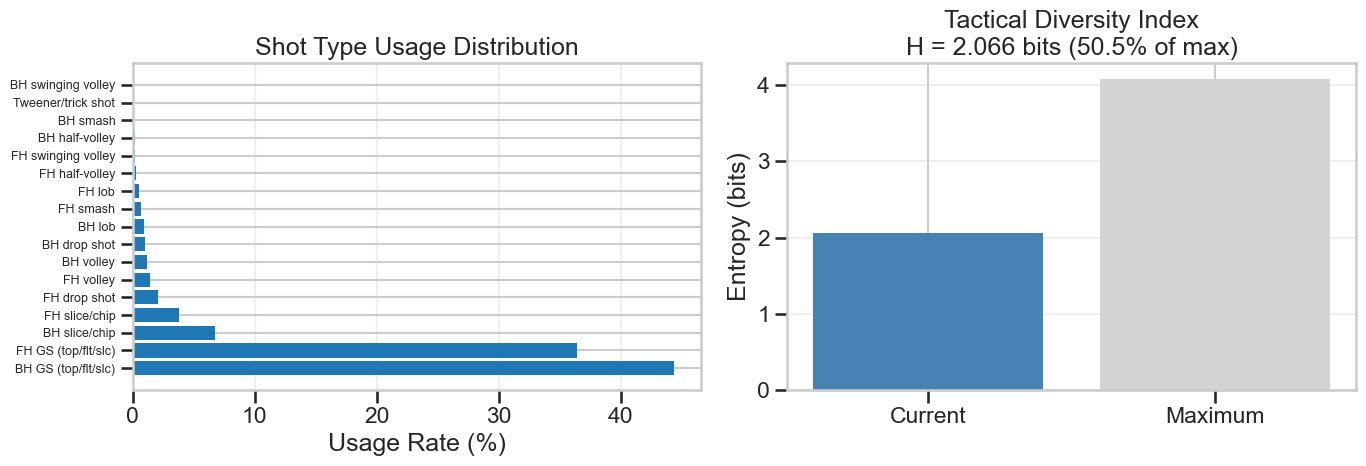

In [17]:
# Compute Shannon entropy
def shannon_entropy(probs):
    """Compute Shannon entropy H = -Σ(p * log(p))"""
    # Remove zeros and NaN (log(0) is undefined, NaN would propagate)
    probs = probs[(probs > 0) & (~np.isnan(probs))]
    if len(probs) == 0:
        return 0.0
    return -np.sum(probs * np.log2(probs))

# Compute entropy for all shot types
usage_probs = df_filtered["UsageRate"].values
entropy = shannon_entropy(usage_probs)

# Maximum possible entropy (if all shots were used equally)
max_entropy = np.log2(len(df_filtered))

# Normalized entropy (0-1 scale, where 1 = maximum diversity)
normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0

print(f"Shannon Entropy (H): {entropy:.3f} bits")
print(f"Maximum possible entropy: {max_entropy:.3f} bits")
print(f"Normalized entropy (diversity index): {normalized_entropy:.3f} (0 = concentrated, 1 = maximum diversity)")

# Interpretation
if normalized_entropy > 0.7:
    interpretation = "High diversity - broad multitasking repertoire"
elif normalized_entropy > 0.4:
    interpretation = "Moderate diversity - balanced shot usage"
else:
    interpretation = "Low diversity - concentrated style"

print(f"\nInterpretation: {interpretation}")

# Visualize usage distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of usage rates
df_sorted = df_filtered.sort_values("UsageRate", ascending=False)
ax1.barh(range(len(df_sorted)), df_sorted["UsageRate"] * 100)
ax1.set_yticks(range(len(df_sorted)))
ax1.set_yticklabels(df_sorted["ShotType"], fontsize=9)
ax1.set_xlabel("Usage Rate (%)")
ax1.set_title("Shot Type Usage Distribution")
ax1.grid(axis="x", alpha=0.3)

# Entropy visualization
ax2.bar(["Current", "Maximum"], [entropy, max_entropy], color=["steelblue", "lightgray"])
ax2.set_ylabel("Entropy (bits)")
ax2.set_title(f"Tactical Diversity Index\nH = {entropy:.3f} bits ({normalized_entropy*100:.1f}% of max)")
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Step 4 · Effectiveness Across Shot Types

For each shot category, compute:
- **Mean Winner%**
- **Mean IndFcd%** (Induced Forced Error %)
- **Mean PtEnd%** (Point-ending rate)
- **Mean UnfErr%** (Unforced Error %)

This answers: **Is Alcaraz effective across multiple shot families, not just one?**

We'll also compute effectiveness metrics by shot category groups (groundstrokes, volleys, drop shots, etc.).

Overall effectiveness across all shot types:


,Mean %
Winner,25.6
IndFcd,8.6
PtEnd,43.3
UnfErr,9.1
inPtsW,58.3



Effectiveness by shot category:


,Winner,IndFcd,PtEnd,UnfErr,inPtsW,Total,UsageRate
Category,,,,,,,
Groundstroke,5.5,5.0,20.0,9.0,54.0,8285100.0,80.8
Slice/Chip,2.0,2.0,7.0,3.5,45.5,1078300.0,10.5
Drop Shot,29.0,12.0,57.5,16.5,62.0,317300.0,3.1
Volley,51.0,9.0,71.0,11.0,74.5,267800.0,2.6
Lob,10.5,7.0,20.5,3.5,40.5,154400.0,1.5
Smash,51.5,14.5,71.5,5.0,81.0,81700.0,0.8
Half-Volley,15.5,13.5,35.0,6.5,56.0,43600.0,0.4
Swinging Volley,52.0,10.0,79.0,17.0,74.5,20900.0,0.2
Trick Shot,2.0,0.0,13.0,11.0,15.0,5400.0,0.1


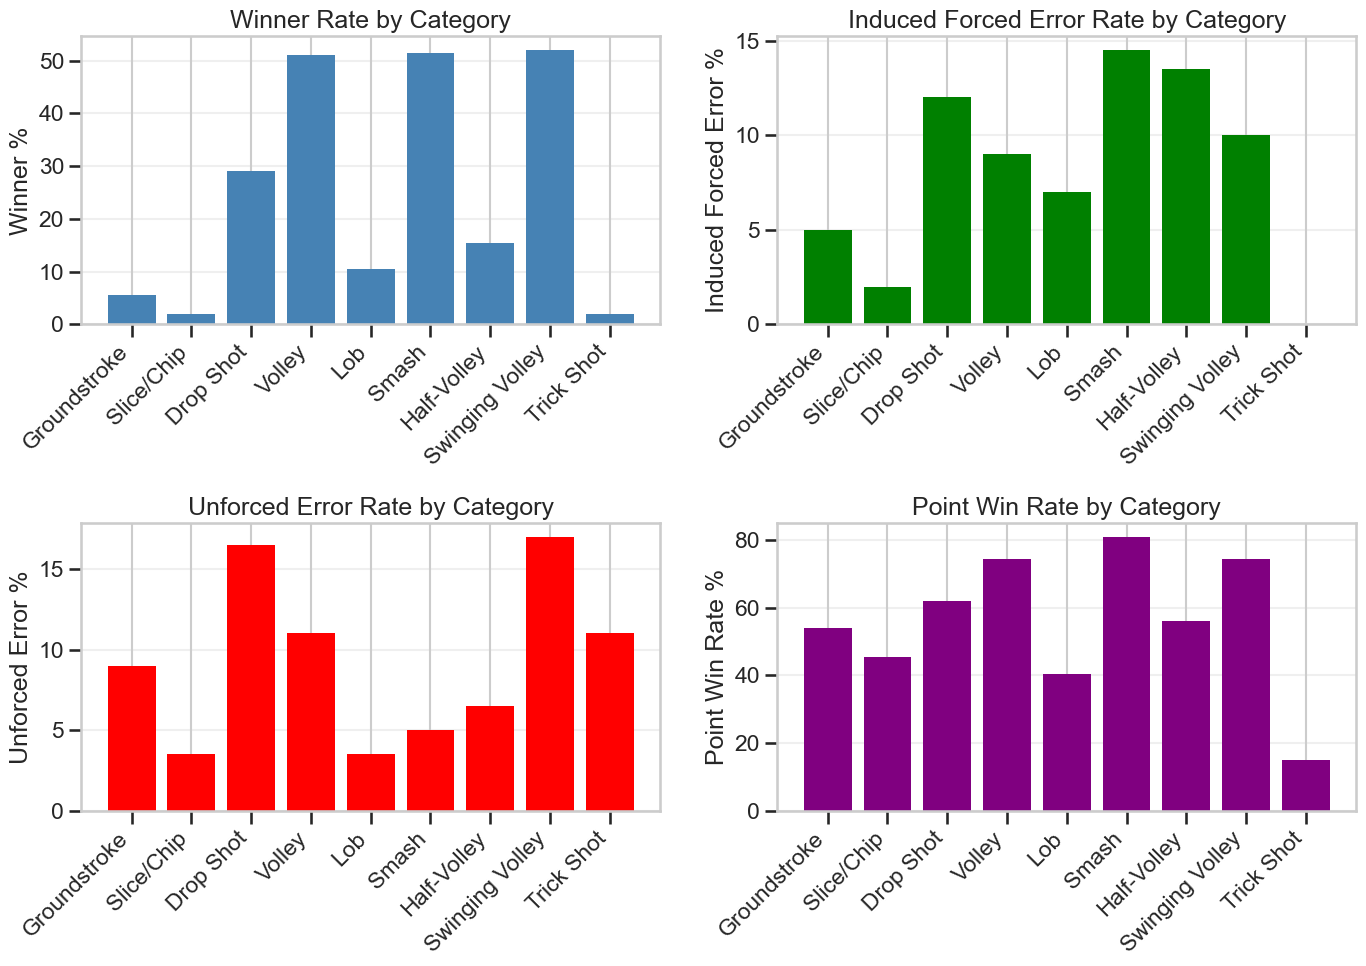

In [18]:
# Compute aggregate effectiveness metrics
effectiveness_cols = ["Winner", "IndFcd", "PtEnd", "UnfErr", "inPtsW"]

print("Overall effectiveness across all shot types:")
overall_effectiveness = df_filtered[effectiveness_cols].mean()
display(overall_effectiveness.to_frame(name="Mean %").round(3) * 100)

# Categorize shots for group analysis
def categorize_shot(shot_name):
    shot_lower = shot_name.lower()
    if "volley" in shot_lower:
        if "swinging" in shot_lower:
            return "Swinging Volley"
        elif "half" in shot_lower:
            return "Half-Volley"
        else:
            return "Volley"
    elif "smash" in shot_lower:
        return "Smash"
    elif "drop" in shot_lower or "dropshot" in shot_lower:
        return "Drop Shot"
    elif "lob" in shot_lower:
        return "Lob"
    elif "slice" in shot_lower or "chip" in shot_lower:
        return "Slice/Chip"
    elif "tweener" in shot_lower or "trick" in shot_lower:
        return "Trick Shot"
    elif "top" in shot_lower or "flat" in shot_lower or "forehand" in shot_lower or "backhand" in shot_lower:
        return "Groundstroke"
    else:
        return "Other"

df_filtered["Category"] = df_filtered["ShotType"].apply(categorize_shot)

# Group effectiveness by category
category_effectiveness = df_filtered.groupby("Category").agg({
    "Winner": "mean",
    "IndFcd": "mean",
    "PtEnd": "mean",
    "UnfErr": "mean",
    "inPtsW": "mean",
    "Total": "sum",
    "UsageRate": "sum"
}).round(3)

category_effectiveness = category_effectiveness.sort_values("Total", ascending=False)

print("\nEffectiveness by shot category:")
display(category_effectiveness * 100)

# Visualize effectiveness across categories
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

categories = category_effectiveness.index
x_pos = np.arange(len(categories))

# Winner %
axes[0, 0].bar(x_pos, category_effectiveness["Winner"] * 100, color="steelblue")
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(categories, rotation=45, ha="right")
axes[0, 0].set_ylabel("Winner %")
axes[0, 0].set_title("Winner Rate by Category")
axes[0, 0].grid(axis="y", alpha=0.3)

# Induced Forced Error %
axes[0, 1].bar(x_pos, category_effectiveness["IndFcd"] * 100, color="green")
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(categories, rotation=45, ha="right")
axes[0, 1].set_ylabel("Induced Forced Error %")
axes[0, 1].set_title("Induced Forced Error Rate by Category")
axes[0, 1].grid(axis="y", alpha=0.3)

# Unforced Error %
axes[1, 0].bar(x_pos, category_effectiveness["UnfErr"] * 100, color="red")
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(categories, rotation=45, ha="right")
axes[1, 0].set_ylabel("Unforced Error %")
axes[1, 0].set_title("Unforced Error Rate by Category")
axes[1, 0].grid(axis="y", alpha=0.3)

# Point Win Rate (inPtsW)
axes[1, 1].bar(x_pos, category_effectiveness["inPtsW"] * 100, color="purple")
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(categories, rotation=45, ha="right")
axes[1, 1].set_ylabel("Point Win Rate %")
axes[1, 1].set_title("Point Win Rate by Category")
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Step 5 · Net Efficiency vs Risk Tradeoff

Define a shot-level **payoff metric**:

**NetPayoff = Winner% + IndFcd% - UnfErr%**

This combines:
- **Positive outcomes**: Winners and Induced Forced Errors
- **Negative outcomes**: Unforced Errors

**Interpretation:**
- **Positive payoff across many categories** = multitasking with control
- **High payoff in only one category** = specialization
- **Negative payoff** = high-risk, low-reward shots

We'll rank shots by payoff and analyze the distribution.

Shot types ranked by NetPayoff (Winner% + IndFcd% - UnfErr%):
FH smash                        Payoff:  64.00%  (W: 63.0% + IF:  9.0% - UE:  8.0%)
BH smash                        Payoff:  58.00%  (W: 40.0% + IF: 20.0% - UE:  2.0%)
FH volley                       Payoff:  57.00%  (W: 57.0% + IF:  9.0% - UE:  9.0%)
FH swinging volley              Payoff:  56.00%  (W: 52.0% + IF: 16.0% - UE: 12.0%)
BH volley                       Payoff:  41.00%  (W: 45.0% + IF:  9.0% - UE: 13.0%)
FH drop shot                    Payoff:  36.00%  (W: 37.0% + IF: 12.0% - UE: 13.0%)
BH swinging volley              Payoff:  34.00%  (W: 52.0% + IF:  4.0% - UE: 22.0%)
FH half-volley                  Payoff:  25.00%  (W: 16.0% + IF: 17.0% - UE:  8.0%)
BH half-volley                  Payoff:  20.00%  (W: 15.0% + IF: 10.0% - UE:  5.0%)
BH lob                          Payoff:  15.00%  (W: 11.0% + IF:  7.0% - UE:  3.0%)
FH lob                          Payoff:  13.00%  (W: 10.0% + IF:  7.0% - UE:  4.0%)
BH drop shot  

,NetPayoff (%)
count,1700.0
mean,25.0
std,24.0
min,-9.0
25%,4.0
50%,20.0
75%,41.0
max,64.0



Shots with positive payoff: 14 / 17 (82.4%)
Shots with negative payoff: 3 / 17 (17.6%)


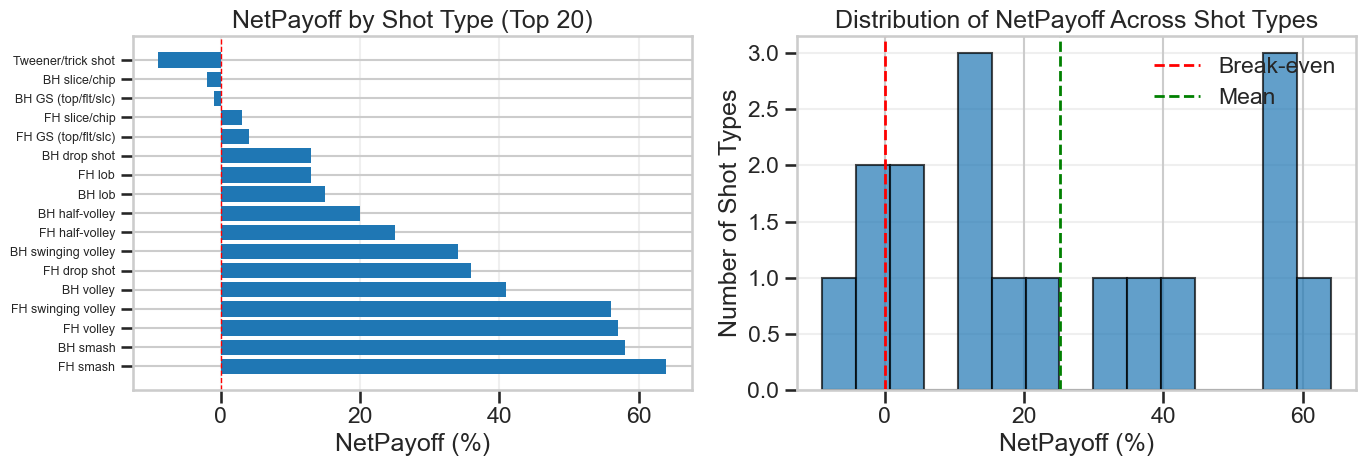


NetPayoff by Category:


,MeanPayoff,StdPayoff,Count
Category,,,
Smash,61.0,4.2,200
Volley,49.0,11.3,200
Swinging Volley,45.0,15.6,200
Drop Shot,24.5,16.3,200
Half-Volley,22.5,3.5,200
Lob,14.0,1.4,200
Groundstroke,1.5,3.5,200
Slice/Chip,0.5,3.5,200
Trick Shot,-9.0,NaN,100


In [19]:
# Compute NetPayoff for each shot type
# Ensure all components are numeric and not NaN (should already be cleaned, but add safeguard)
df_filtered["NetPayoff"] = (
    df_filtered["Winner"].fillna(0) + 
    df_filtered["IndFcd"].fillna(0) - 
    df_filtered["UnfErr"].fillna(0)
)

# Sort by payoff
df_payoff = df_filtered.sort_values("NetPayoff", ascending=False).copy()

print("Shot types ranked by NetPayoff (Winner% + IndFcd% - UnfErr%):")
print("=" * 80)
for idx, row in df_payoff.iterrows():
    payoff_pct = row["NetPayoff"] * 100
    print(f"{row['ShotType']:30s}  Payoff: {payoff_pct:6.2f}%  "
          f"(W:{row['Winner']*100:5.1f}% + IF:{row['IndFcd']*100:5.1f}% - UE:{row['UnfErr']*100:5.1f}%)")

# Summary statistics
print("\n" + "=" * 80)
print("NetPayoff Summary Statistics:")
payoff_summary = df_filtered["NetPayoff"].describe()
display(payoff_summary.to_frame(name="NetPayoff (%)").round(2) * 100)

# Count shots with positive vs negative payoff
positive_payoff = (df_filtered["NetPayoff"] > 0).sum()
negative_payoff = (df_filtered["NetPayoff"] <= 0).sum()

print(f"\nShots with positive payoff: {positive_payoff} / {len(df_filtered)} ({positive_payoff/len(df_filtered)*100:.1f}%)")
print(f"Shots with negative payoff: {negative_payoff} / {len(df_filtered)} ({negative_payoff/len(df_filtered)*100:.1f}%)")

# Visualize payoff distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of payoffs
df_sorted_payoff = df_payoff.head(20)  # Top 20 for readability
ax1.barh(range(len(df_sorted_payoff)), df_sorted_payoff["NetPayoff"] * 100)
ax1.set_yticks(range(len(df_sorted_payoff)))
ax1.set_yticklabels(df_sorted_payoff["ShotType"], fontsize=9)
ax1.axvline(0, color="red", linestyle="--", linewidth=1)
ax1.set_xlabel("NetPayoff (%)")
ax1.set_title("NetPayoff by Shot Type (Top 20)")
ax1.grid(axis="x", alpha=0.3)

# Histogram of payoffs
ax2.hist(df_filtered["NetPayoff"] * 100, bins=15, edgecolor="black", alpha=0.7)
ax2.axvline(0, color="red", linestyle="--", linewidth=2, label="Break-even")
ax2.axvline(df_filtered["NetPayoff"].mean() * 100, color="green", linestyle="--", linewidth=2, label="Mean")
ax2.set_xlabel("NetPayoff (%)")
ax2.set_ylabel("Number of Shot Types")
ax2.set_title("Distribution of NetPayoff Across Shot Types")
ax2.legend()
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Payoff by category
category_payoff = df_filtered.groupby("Category").agg({
    "NetPayoff": ["mean", "std", "count"]
}).round(3)
category_payoff.columns = ["MeanPayoff", "StdPayoff", "Count"]

print("\nNetPayoff by Category:")
display(category_payoff.sort_values("MeanPayoff", ascending=False) * 100)

### Step 6 · Heterogeneity Across Shot Types

**Important:** This analysis measures **heterogeneity BETWEEN shot types**, not consistency ACROSS matches.

**What we cannot measure with aggregated data:**
- Std dev of entropy across matches (requires per-match data)
- Std dev of payoff metrics across matches (requires per-match data)
- Whether shot diversity remains stable under pressure (requires per-match data)

**What we can measure:**
- **Variability in effectiveness** across different shot types (coefficient of variation)
- **Heterogeneity of payoff** across shot categories

**Interpretation:**
- A **low coefficient of variation** means effectiveness is similar across shot types (homogeneous portfolio)
- A **high coefficient of variation** means effectiveness varies significantly between shot types (heterogeneous portfolio)
- This tells us about the **structure of the portfolio**, not about **performance stability over time**

Heterogeneity Analysis (Coefficient of Variation):
This measures how much effectiveness varies BETWEEN shot types,
not how consistent Alcaraz is ACROSS matches (which requires per-match data).
Lower CV = more homogeneous effectiveness across shot types


,Mean,Std,CV
inPtsW,0.583,0.180,0.309
UnfErr,0.091,0.058,0.631
PtEnd,0.433,0.276,0.638
IndFcd,0.086,0.056,0.648
Winner,0.256,0.219,0.854
NetPayoff,0.251,0.237,0.942



Interpretation (heterogeneity between shot types):
  inPtsW         : CV = 0.309 (Moderate heterogeneity)
  UnfErr         : CV = 0.631 (High heterogeneity)
  PtEnd          : CV = 0.638 (High heterogeneity)
  IndFcd         : CV = 0.648 (High heterogeneity)
  Winner         : CV = 0.854 (Very high heterogeneity (large differences between shot types))
  NetPayoff      : CV = 0.942 (Very high heterogeneity (large differences between shot types))


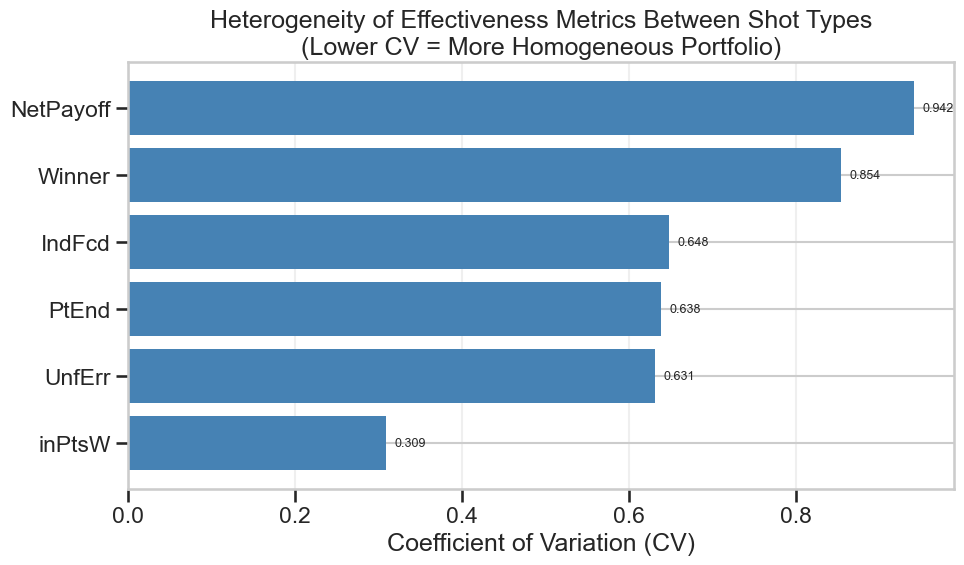


NetPayoff Heterogeneity by Category:


,mean,std,count,CV
Category,,,,
Smash,0.610,0.042,2,0.070
Lob,0.140,0.014,2,0.101
Half-Volley,0.225,0.035,2,0.157
Volley,0.490,0.113,2,0.231
Swinging Volley,0.450,0.156,2,0.346
Drop Shot,0.245,0.163,2,0.664
Groundstroke,0.015,0.035,2,2.357
Slice/Chip,0.005,0.035,2,7.071
Trick Shot,-0.090,NaN,1,NaN


In [20]:
# Compute coefficient of variation (CV) for effectiveness metrics
# CV = std / mean, lower CV = more consistent performance

effectiveness_metrics = ["Winner", "IndFcd", "PtEnd", "UnfErr", "NetPayoff", "inPtsW"]

cv_results = {}
for metric in effectiveness_metrics:
    # Ensure no NaN in the metric column
    metric_data = df_filtered[metric].dropna()
    if len(metric_data) == 0:
        print(f"Warning: {metric} has no valid data")
        continue
    mean_val = metric_data.mean()
    std_val = metric_data.std()
    # Handle edge case where mean is 0 or very small
    if mean_val > 1e-10:  # Avoid division by zero
        cv = std_val / mean_val
    else:
        cv = np.nan
    cv_results[metric] = {
        "Mean": mean_val,
        "Std": std_val,
        "CV": cv
    }

cv_df = pd.DataFrame(cv_results).T
cv_df = cv_df.sort_values("CV")

print("Heterogeneity Analysis (Coefficient of Variation):")
print("This measures how much effectiveness varies BETWEEN shot types,")
print("not how consistent Alcaraz is ACROSS matches (which requires per-match data).")
print("Lower CV = more homogeneous effectiveness across shot types")
print("=" * 80)
display(cv_df.round(3))

# Interpretation
print("\nInterpretation (heterogeneity between shot types):")
for metric in cv_df.index:
    cv_val = cv_df.loc[metric, "CV"]
    if cv_val < 0.3:
        heterogeneity = "Low heterogeneity (similar across shot types)"
    elif cv_val < 0.5:
        heterogeneity = "Moderate heterogeneity"
    elif cv_val < 0.8:
        heterogeneity = "High heterogeneity"
    else:
        heterogeneity = "Very high heterogeneity (large differences between shot types)"
    print(f"  {metric:15s}: CV = {cv_val:.3f} ({heterogeneity})")

# Visualize consistency
fig, ax = plt.subplots(figsize=(10, 6))
metrics = cv_df.index
cv_values = cv_df["CV"].values

bars = ax.barh(metrics, cv_values, color="steelblue")
ax.set_xlabel("Coefficient of Variation (CV)")
ax.set_title("Heterogeneity of Effectiveness Metrics Between Shot Types\n(Lower CV = More Homogeneous Portfolio)")
ax.grid(axis="x", alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, cv_values)):
    ax.text(val + 0.01, i, f"{val:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

# Consistency by category
category_consistency = df_filtered.groupby("Category")["NetPayoff"].agg(["mean", "std", "count"])
category_consistency["CV"] = category_consistency["std"] / category_consistency["mean"]
category_consistency = category_consistency.sort_values("CV")

print("\nNetPayoff Heterogeneity by Category:")
display(category_consistency.round(3))

### Step 7 · Diversity-Effectiveness Relationship

Analyze the relationship between **shot usage frequency** and **effectiveness**:

- Do frequently used shots have higher effectiveness?
- Are rare shots less effective, or do they maintain quality?
- Is there a tradeoff between diversity (even usage) and specialization (concentrated usage)?

**Statistical note:** With n=15-20 shot types, correlation analysis has limited statistical power. Results should be interpreted descriptively rather than inferentially.

Correlation Matrix: Usage Rate vs Effectiveness Metrics


,UsageRate,Winner,IndFcd,UnfErr,NetPayoff,inPtsW,PtEnd
UsageRate,1.000,-0.392,-0.301,-0.049,-0.422,-0.117,-0.375
Winner,-0.392,1.000,0.468,0.391,0.941,0.875,0.973
IndFcd,-0.301,0.468,1.000,-0.008,0.671,0.610,0.574
UnfErr,-0.049,0.391,-0.008,1.000,0.117,0.229,0.519
NetPayoff,-0.422,0.941,0.671,0.117,1.000,0.897,0.909
inPtsW,-0.117,0.875,0.610,0.229,0.897,1.000,0.869
PtEnd,-0.375,0.973,0.574,0.519,0.909,0.869,1.000



Correlations with Usage Rate:
  UnfErr         : -0.049 (weak negative correlation)
  inPtsW         : -0.117 (weak negative correlation)
  IndFcd         : -0.301 (moderate negative correlation)
  PtEnd          : -0.375 (moderate negative correlation)
  Winner         : -0.392 (moderate negative correlation)
  NetPayoff      : -0.422 (moderate negative correlation)


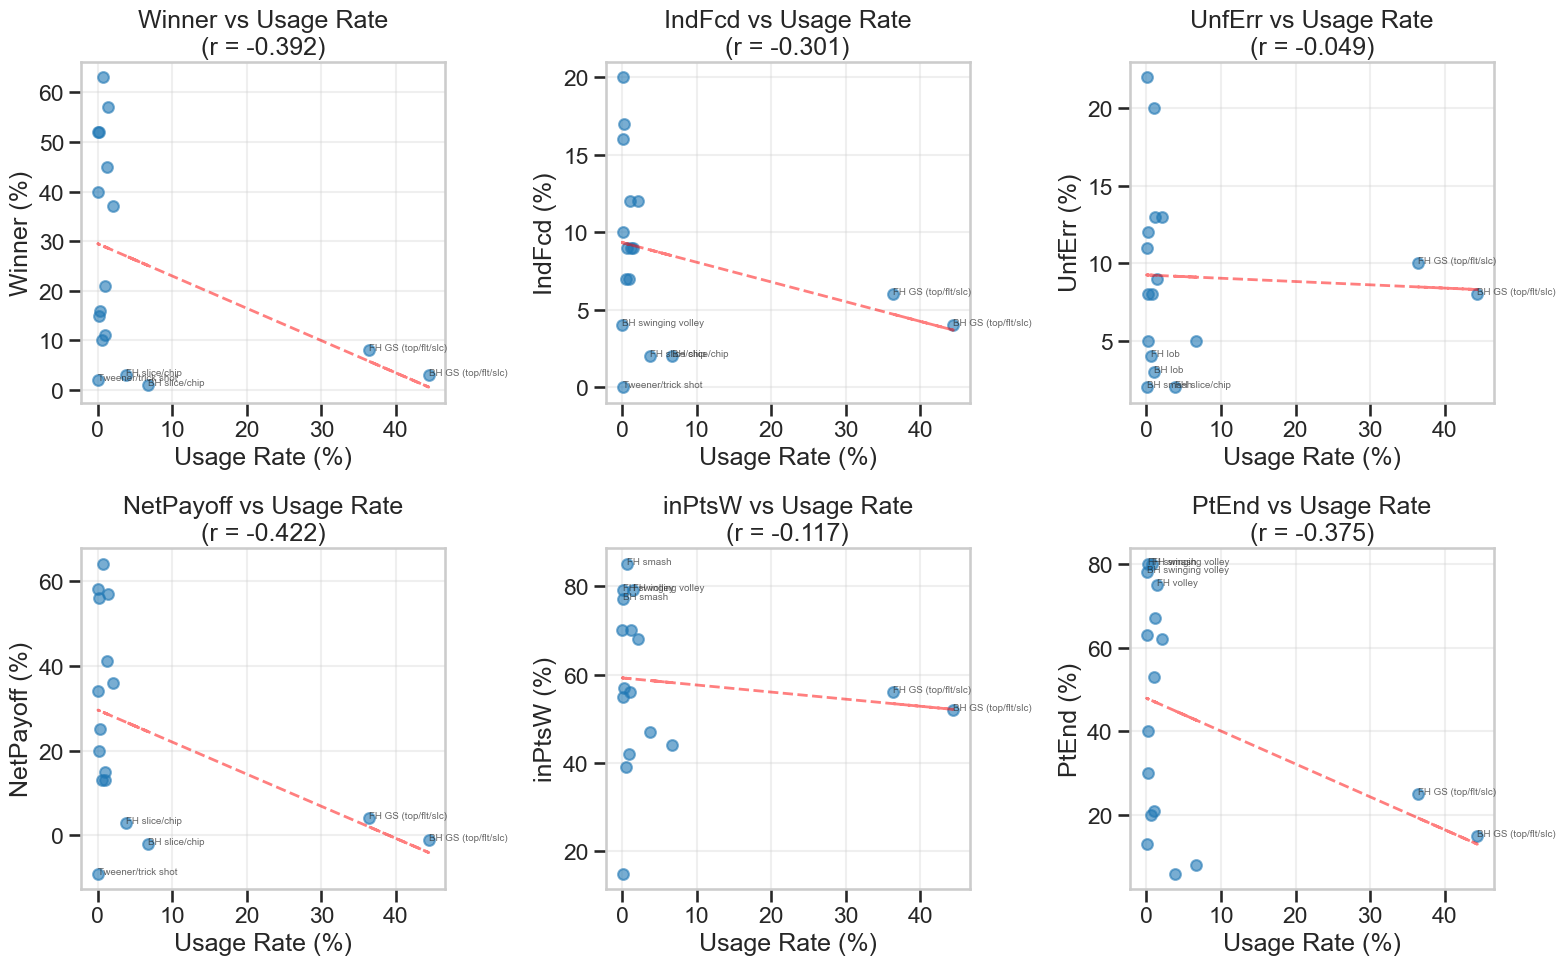


Effectiveness: Rare vs Common Shots:


,Winner,IndFcd,UnfErr,NetPayoff,inPtsW
UsageCategory,,,,,
Common (≥5%),4.0,4.0,7.7,0.3,50.7
Rare (<5%),30.3,9.6,9.4,30.4,59.9


In [21]:
# Compute correlations between usage rate and effectiveness metrics
correlation_metrics = ["UsageRate", "Winner", "IndFcd", "UnfErr", "NetPayoff", "inPtsW", "PtEnd"]

corr_matrix = df_filtered[correlation_metrics].corr()

print("Correlation Matrix: Usage Rate vs Effectiveness Metrics")
print("=" * 80)
display(corr_matrix.round(3))

# Focus on correlations with UsageRate
usage_corrs = corr_matrix["UsageRate"].drop("UsageRate").sort_values(ascending=False)

print("\nCorrelations with Usage Rate:")
print("=" * 80)
for metric, corr_val in usage_corrs.items():
    direction = "positive" if corr_val > 0 else "negative"
    strength = "strong" if abs(corr_val) > 0.5 else "moderate" if abs(corr_val) > 0.3 else "weak"
    print(f"  {metric:15s}: {corr_val:6.3f} ({strength} {direction} correlation)")

# Scatter plots: Usage Rate vs Effectiveness
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

metrics_to_plot = ["Winner", "IndFcd", "UnfErr", "NetPayoff", "inPtsW", "PtEnd"]

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.scatter(df_filtered["UsageRate"] * 100, df_filtered[metric] * 100, alpha=0.6, s=60)
    
    # Add shot type labels for extreme points
    for idx, row in df_filtered.iterrows():
        if row["UsageRate"] > 0.15 or row[metric] > 0.7 or row[metric] < 0.05:
            ax.annotate(row["ShotType"], 
                       (row["UsageRate"] * 100, row[metric] * 100),
                       fontsize=7, alpha=0.7)
    
    # Add correlation line
    z = np.polyfit(df_filtered["UsageRate"] * 100, df_filtered[metric] * 100, 1)
    p = np.poly1d(z)
    ax.plot(df_filtered["UsageRate"] * 100, p(df_filtered["UsageRate"] * 100), 
           "r--", alpha=0.5, linewidth=2)
    
    corr_val = corr_matrix.loc["UsageRate", metric]
    ax.set_xlabel("Usage Rate (%)")
    ax.set_ylabel(f"{metric} (%)")
    ax.set_title(f"{metric} vs Usage Rate\n(r = {corr_val:.3f})")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze rare vs common shots
rare_threshold = 0.05  # 5% usage
df_filtered["UsageCategory"] = df_filtered["UsageRate"].apply(
    lambda x: "Rare (<5%)" if x < rare_threshold else "Common (≥5%)"
)

comparison = df_filtered.groupby("UsageCategory").agg({
    "Winner": "mean",
    "IndFcd": "mean",
    "UnfErr": "mean",
    "NetPayoff": "mean",
    "inPtsW": "mean"
}).round(3)

print("\nEffectiveness: Rare vs Common Shots:")
display(comparison * 100)

### Summary: Shot Portfolio Characterization

**Key Findings:**

1. **Shot Repertoire Breadth**: Number of active shot types and diversity index
2. **Tactical Diversity**: Shannon entropy score (portfolio-level, not match-to-match)
3. **Cross-Category Effectiveness**: Performance across different shot families
4. **Net Efficiency**: Payoff metrics showing risk-reward balance
5. **Heterogeneity**: Variability in effectiveness between shot types (not across matches)
6. **Diversity-Effectiveness Relationship**: Relationship between usage frequency and effectiveness

**Conclusion:**

Alcaraz maintains positive efficiency (NetPayoff) across a broad shot repertoire, demonstrating effectiveness across multiple shot families. The aggregated data confirms tactical breadth in the overall portfolio; per-match data would be needed to assess tactical flexibility within matches or stability of diversity under pressure.

In [22]:
# Compile summary statistics
print("=" * 80)
print("SHOT PORTFOLIO CHARACTERIZATION SUMMARY")
print("=" * 80)

print(f"\n1. SHOT REPERTOIRE BREADTH:")
print(f"   Total shot types: {len(df_filtered)}")
print(f"   Active shot types (usage > 1%): {active_shots}")
print(f"   Total shots analyzed: {df_filtered['Total'].sum():,.0f}")

print(f"\n2. TACTICAL DIVERSITY INDEX:")
print(f"   Shannon Entropy: {entropy:.3f} bits")
print(f"   Normalized Entropy: {normalized_entropy:.3f} ({normalized_entropy*100:.1f}% of maximum)")
print(f"   Interpretation: {interpretation}")

print(f"\n3. OVERALL EFFECTIVENESS:")
for metric in ["Winner", "IndFcd", "UnfErr", "NetPayoff", "inPtsW"]:
    mean_val = df_filtered[metric].mean() * 100
    print(f"   {metric:15s}: {mean_val:6.2f}%")

print(f"\n4. NET EFFICIENCY (PAYOFF):")
print(f"   Mean NetPayoff: {df_filtered['NetPayoff'].mean()*100:.2f}%")
print(f"   Shots with positive payoff: {positive_payoff}/{len(df_filtered)} ({positive_payoff/len(df_filtered)*100:.1f}%)")

print(f"\n5. HETEROGENEITY (COEFFICIENT OF VARIATION):")
print("   (Measures differences BETWEEN shot types, not consistency ACROSS matches)")
for metric in ["Winner", "IndFcd", "NetPayoff"]:
    cv_val = cv_df.loc[metric, "CV"]
    print(f"   {metric:15s} CV: {cv_val:.3f}")

print(f"\n6. DIVERSITY-EFFECTIVENESS RELATIONSHIP:")
usage_netpayoff_corr = corr_matrix.loc["UsageRate", "NetPayoff"]
print(f"   Correlation (Usage Rate vs NetPayoff): {usage_netpayoff_corr:.3f}")

print("\n" + "=" * 80)
print("CONCLUSION:")
print("=" * 80)
print("Alcaraz maintains positive efficiency (NetPayoff) across a broad shot")
print("repertoire, demonstrating effectiveness across multiple shot families.")
print("The aggregated data confirms tactical breadth in the overall portfolio;")
print("per-match data would be needed to assess tactical flexibility within")
print("matches or stability of diversity under pressure.")
print("=" * 80)

SHOT PORTFOLIO CHARACTERIZATION SUMMARY

1. SHOT REPERTOIRE BREADTH:
   Total shot types: 17
   Active shot types (usage > 1%): 7
   Total shots analyzed: 102,545

2. TACTICAL DIVERSITY INDEX:
   Shannon Entropy: 2.066 bits
   Normalized Entropy: 0.505 (50.5% of maximum)
   Interpretation: Moderate diversity - balanced shot usage

3. OVERALL EFFECTIVENESS:
   Winner         :  25.65%
   IndFcd         :   8.59%
   UnfErr         :   9.12%
   NetPayoff      :  25.12%
   inPtsW         :  58.29%

4. NET EFFICIENCY (PAYOFF):
   Mean NetPayoff: 25.12%
   Shots with positive payoff: 14/17 (82.4%)

5. HETEROGENEITY (COEFFICIENT OF VARIATION):
   (Measures differences BETWEEN shot types, not consistency ACROSS matches)
   Winner          CV: 0.854
   IndFcd          CV: 0.648
   NetPayoff       CV: 0.942

6. DIVERSITY-EFFECTIVENESS RELATIONSHIP:
   Correlation (Usage Rate vs NetPayoff): -0.422

CONCLUSION:
Alcaraz maintains positive efficiency (NetPayoff) across a broad shot
repertoire, demon

### What This Analysis Claims
✅ Alcaraz deploys a broad shot repertoire across match play  
✅ Shot diversity is accompanied by high conversion (Winner% + IndFcd%)  
✅ Error rates remain controlled despite tactical complexity  
✅ Tactical switching is sustained rather than situational

### What This Analysis Does NOT Claim
❌ That shot choice is intentional or conscious  
❌ That diversity alone causes winning  
❌ That rare shots (tweeners) drive outcomes  
❌ That this is biomechanical speed